# FEATURE ENGINEERING

Este punto debe cubrir un ejercicio de feature engineering; creación de nuevas variables a partir de las variables seleccionadas como válidas en la práctica 2. 


Las variables añadidas, deben ser evaluadas con el mismo proceso que el resto de variables, es decir, IV, PSI, y correlación. Si pasa estos filtros, se debe evaluar si la feature diseñada mejora el rendimiento del modelo o no.



- Tasas de variables en diferentes momentos temporales, por ejemplo: PublicRecordsLast10Yeards / 12 Months
- Transformaciones matemáticas a las features: Log, exp, transformaciones no monótonas, …
- Transformaciones con sentido de ‘negocio’ 
- Propuesta de interaction terms


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#BoxCox
from scipy import stats
from sklearn import preprocessing
%matplotlib inline

## LECTURA DE DATOS

In [92]:
df = pd.read_csv('prosperLoanData_train.csv')
df_oot = pd.read_csv('prosperLoanData_oot.csv')

E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [93]:
df_val = pd.read_csv('./prosperLoanData_val.csv')

Partimos del drop de columnas de nuestra práctica inicial

In [94]:
drop = ["LoanStatus","ClosedDate","BorrowerAPR","ListingKey","ListingNumber","ListingCreationDate","Term",
             "CreditGrade","BorrowerRate","LenderYield","EstimatedEffectiveYield","EstimatedLoss",
             "EstimatedReturn","BorrowerState","CurrentlyInGroup",
             "GroupKey","DateCreditPulled","PublicRecordsLast10Years",
             "PublicRecordsLast12Months","RevolvingCreditBalance","BankcardUtilization","AvailableBankcardCredit",
             "TradesOpenedLast6Months","DebtToIncomeRatio","IncomeVerifiable","LoanKey",'TotalProsperLoans',
             'TotalProsperPaymentsBilled','OnTimeProsperPayments','ProsperPaymentsLessThanOneMonthLate','ProsperPaymentsOneMonthPlusLate',
             'ProsperPrincipalBorrowed','ProsperPrincipalOutstanding','LoanCurrentDaysDelinquent','LoanFirstDefaultedCycleNumber','LoanMonthsSinceOrigination',
             'LoanNumber',"LP_CustomerPrincipalPayments",'LoanOriginationDate','LoanOriginationQuarter',
             'LP_CustomerPrincipalPayments','LP_CustomerPayments','MonthlyLoanPayment','MemberKey',
             "LP_InterestandFees","LP_ServiceFees","LP_CollectionFees","LP_GrossPrincipalLoss",
             "LP_NetPrincipalLoss","LP_NonPrincipalRecoverypayments","Recommendations", "InvestmentFromFriendsCount","Investors",
             "InvestmentFromFriendsAmount", "bad_aux", "PW", "bad_rate", "bad", 'fraud', 'indeterm', 'LoanOriginationYear', 'LoanMonthsSinceOriginationY',
            'ProsperRating (numeric)', 
            'ProsperRating (Alpha)', 'ProsperScore', 'FirstRecordedCreditLine']

In [95]:
features = [c for c in df.columns if c not in drop]
col_target = 'bad'

La idea básica es aplicar transformaciones a las columnas restantes de manera que mejoren de alguna manera el modelo, en base al IV y al PSI. Se unirán variables, se disminuirán rangos y se aplicará la transformación de Box-Cox

# Matriz de correlaciones

Podemos observar que existen numerosas variables que están muy correlacionadas y que se podrían eliminar, para que en nuestro modelo no afecte la multicolinealidad.

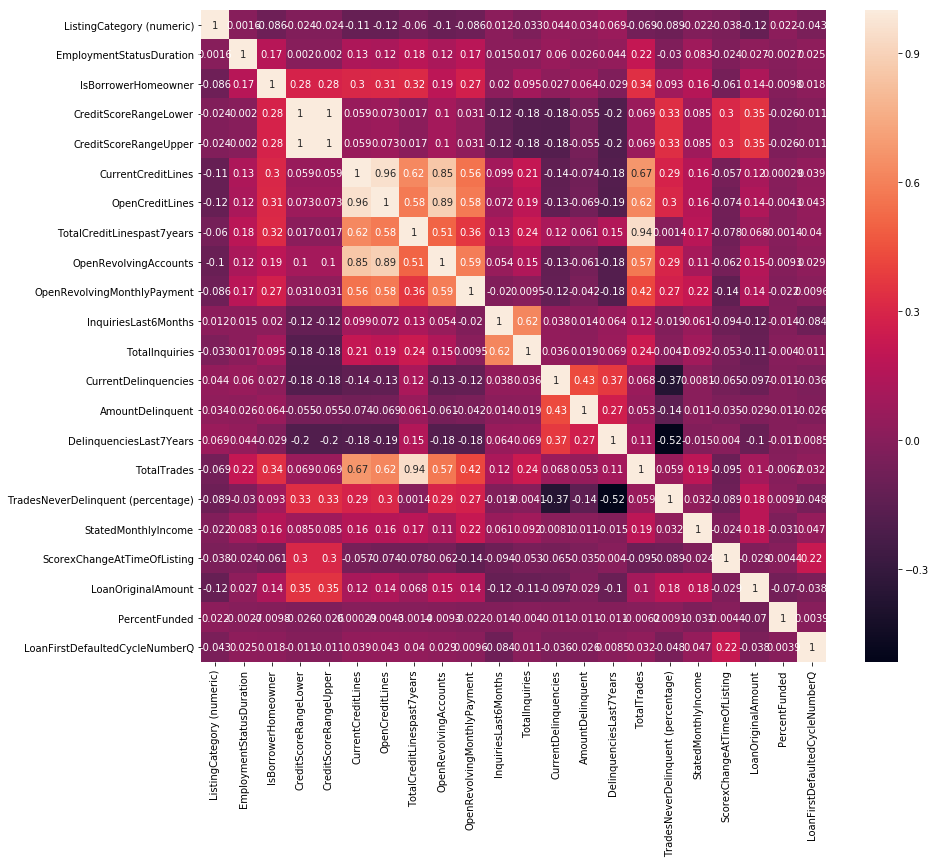

In [96]:
corr = df[features].corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g")

## CREACIÓN DE VARIABLES

A partir de las variables numéricas que tenemos, aquellas cuya distribución no se ajuste o parezca a una normal se van a pasar a categóricas intentando que el modelo se mejore.

In [97]:
def emp_stat_dur(x):
    if (x >=0. and x <= 120):
        return 0
    elif ( x >120 and x <= 240):
        return 1
    elif ( x >240 and x <=360):
        return 2
    elif (x> 360 and x <= 420):
        return 3
    elif(x>420 and x <= 520):
        return 4
    else:
        return 5

In [98]:
new_stat_dur= df[features[3]].apply(emp_stat_dur)

In [99]:
def current_lines(x):
    if (x >=0. and x <= 10):
        return 0
    elif ( x >10 and x <= 20):
        return 1
    elif ( x >20 and x <=30):
        return 2
    elif (x> 30 and x <= 40):
        return 3

In [100]:
new_current_lines= df['CurrentCreditLines'].apply(current_lines)

In [101]:
def open_lines(x):
    if (x >=0. and x <= 10):
        return 0
    elif ( x >10 and x <= 20):
        return 1
    elif ( x >20 and x <=30):
        return 2
    elif (x> 30 and x <= 40):
        return 3

In [102]:
new_open_lines= df['OpenCreditLines'].apply(open_lines)
new_open_lines.unique()

array([0, 1, 2, 3], dtype=int64)

In [103]:
def total_credit_7years(x):
    if (x >=0. and x <= 20):
        return 0
    elif ( x >20 and x <= 40):
        return 1
    elif ( x >40 and x <=60):
        return 2
    elif (x> 60 and x <= 80):
        return 3
    elif (x > 80 and x<= 100):
        return 4
    else:
        return 5

In [104]:
new_credit_7years= df['TotalCreditLinespast7years'].apply(total_credit_7years)
new_credit_7years.unique()

array([1, 0, 2, 3, 4, 5], dtype=int64)

In [105]:
def revolving_acounts(x):
    if (x >=0. and x <= 10):
        return 0
    elif ( x >10 and x <= 20):
        return 1
    elif ( x >20 and x <=30):
        return 2
    elif (x> 30 and x <= 40):
        return 3

In [106]:
new_revolving_accounts= df['OpenRevolvingAccounts'].apply(revolving_acounts)
new_revolving_accounts.unique()

array([0, 1, 2, 3], dtype=int64)

In [107]:
def revolving_accounts_monthly(x):
    if (x >=0. and x <= 1000):
        return 0
    elif ( x >1000 and x <= 2000):
        return 1
    elif ( x >2000 and x <=3000):
        return 2
    elif (x> 3000 and x <= 4000):
        return 3
    elif (x> 4000 and x< 5000):
        return 4
    else:
        return 5

In [108]:
new_revolving_accounts_monthly= df['OpenRevolvingMonthlyPayment'].apply(revolving_accounts_monthly)
new_revolving_accounts_monthly.unique()

array([0, 1, 2, 3, 5, 4], dtype=int64)

In [109]:
def inquiring_6months(x):
    if (x >=0. and x <= 10):
        return 0
    elif ( x >10 and x <= 20):
        return 1
    else:
        return 2

In [110]:
new_inquiring= df['InquiriesLast6Months'].apply(inquiring_6months)
new_inquiring.unique()

array([0, 2, 1], dtype=int64)

In [112]:
categ_features = [f for f, b in zip(features, df[features].dtypes == object) if b==True]
numeric_features = [f for f in features if f not in categ_features]

In [115]:
def change_employment(x):
    if (x == 'Other' or x == 'Not employed' or x == 'Retired'):
        return 0 
    else:
        return 1
    
new_employment_status = df.EmploymentStatus.apply(change_employment)

In [116]:
def change_Income_Range(x):
    if (x == '$0' or x == 'Not employed'):
        return 'Becario Precario'
    elif  (x == '$1-24,999' or x == '$25,000-49,999' or  x == '$50,000-74,999'):
        return 'Clase Media' 
    else: 
        return 'Clase Alta'
    
new_Income_Range = df.IncomeRange.apply(change_Income_Range)

In [119]:
def total_inquiries(x):
    if (x >=0. and x <= 10):
        return 0
    elif ( x >10 and x <= 20):
        return 1
    elif ( x >20 and x <=30):
        return 2
    elif (x> 30 and x <= 40):
        return 3
    elif (x> 40 and x<= 50):
        return 4
    elif (x> 50 and x<= 60):
        return 5
    elif (x> 60 and x<= 71):
        return 6
    else:
        return 7

new_total_inq = df.TotalInquiries.apply(total_inquiries)

In [120]:
def amount_delinquent(x):
    if (x >= 0. and x <= 100000):
        return 0
    elif ( x >100000 and x <= 200000):
        return 1
    elif ( x > 200000 and x <= 300000):
        return 2
    
new_amount_del = df.AmountDelinquent.apply(amount_delinquent)

In [121]:
def Stated_Monthly_Income(x):
    if (x >= 0. and x <= 100000):
        return 0
    elif ( x >100000 and x <= 200000):
        return 1
    elif ( x > 200000 and x <= 300000):
        return 2     
    elif ( x >300000 and x <= 400000):
        return 3
    else:
        return 4
    
new_stated_month = df.StatedMonthlyIncome.apply(Stated_Monthly_Income)

Una vez hemos obtenido los vectores de categorias vamos a pasárselos al dataframe original.

In [122]:
df.EmploymentStatusDuration = new_stat_dur

In [123]:
df.CurrentCreditLines = new_current_lines

In [124]:
df.OpenCreditLines = new_open_lines

In [125]:
df.TotalCreditLinespast7years = new_credit_7years

In [126]:
df.OpenRevolvingAccounts = new_revolving_accounts

In [127]:
df.OpenRevolvingMonthlyPayment = new_revolving_accounts_monthly

In [128]:
df.InquiriesLast6Months = new_inquiring

In [129]:
df.EmploymentStatus = new_employment_status

In [130]:
#df.IncomeRange = new_Income_Range

In [131]:
df.TotalInquiries = new_total_inq

In [132]:
df.AmountDelinquent = new_amount_del

In [133]:
df.StatedMonthlyIncome = new_stated_month

In [134]:
df[numeric_features].head()

,ListingCategory (numeric),EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,...,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,TotalTrades,TradesNeverDelinquent (percentage),StatedMonthlyIncome,ScorexChangeAtTimeOfListing,LoanOriginalAmount,PercentFunded,LoanFirstDefaultedCycleNumberQ
0,1,0,True,660.0,679.0,0,0,1,0,0,...,0.0,0,0.0,17.0,1.00,0,NaN,4000,1.0000,NaN
1,6,0,False,660.0,679.0,0,0,0,0,0,...,0.0,0,0.0,6.0,1.00,0,NaN,4000,1.0000,12.0
2,3,0,True,660.0,679.0,0,0,0,0,0,...,1.0,0,42.0,16.0,0.61,0,19.0,1000,1.0000,NaN
3,3,0,False,700.0,719.0,0,0,1,0,0,...,2.0,0,28.0,27.0,0.66,0,NaN,2861,0.7151,NaN
4,1,1,True,700.0,719.0,0,0,0,0,0,...,0.0,0,0.0,17.0,0.94,0,NaN,3500,1.0000,NaN


In [135]:
# Tenemos que transformar aquellos valores que son 0 en algo superior si no BoxCox no funciona
def transform_zeros(x):
    if x == 0:
        return 0.1
    else:
        return x
    
for col in numeric_features:
    df[col] = df[col].apply(transform_zeros)

In [136]:
#visualization functions
def capture_df(feat_col, input_slider, n_bins, df, target_col):
    """
    Handles the type of the data to generate the intermediate datadframe
    """
    if df[feat_col].dtype in [int, float, np.number]:
        return df_vol_br_num(feat_col, input_slider, n_bins, df, target_col)
    else:
        return df_vol_br_cat(feat_col, input_slider, n_bins, df, target_col)

#capture volume / BR df for numerical variables
def df_vol_br_num(feat_col, input_slider, n_bins, df, obj_col):
    """
    Generate the intermediate dataframe with number of observations and 
    number of bads per bin. Specific for numerical features.
    """
    #get the numeric input from the dual slider
    perc_sliders = [v/100. for v in input_slider]
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[obj_col, feat_col]]
    #number of cuts = minumum of n_bins, number of unique values of the variable
    n_cuts = min(int(n_bins), df_cut[feat_col].nunique())
    cuts = [c for c in np.linspace(v_min, v_max, n_cuts + 1)]
    if cuts[-1] < v_max:
        cuts.append(v_max)
    cut_col = feat_col + '_'
    df_cut[cut_col] = pd.cut(df_cut[feat_col], cuts, include_lowest=True)
    #generate aggregated values
    N = df_cut.groupby(cut_col)[feat_col].count().values
    TR = df_cut.groupby(cut_col)[obj_col].mean().values
    cuts = df_cut.groupby(cut_col)[feat_col].count().index.astype(str).values
    #handle NA entries
    if df[feat_col].isna().sum() > 0:
        N = np.append(([df[feat_col].isna().sum()]), N)
        TR = np.append(([df.loc[df[feat_col].isna()][obj_col].mean()]), TR)
        cuts =  np.append(['NA'], cuts)
    #generate global transformation rate
    return (pd.DataFrame({'cuts': cuts,
                         'N': N,
                         'BR': TR}), df_cut[obj_col].mean())

#capture volume / BR df for categorical variables
def df_vol_br_cat(feat_col, input_slider, n_bins, df, target_col):
    """
    Generate the intermediate dataframe with number of observations and 
    number of bads per bin. Specific for categorical features.
    """
    #pick top n_bins levels by volume
    cut_levels = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    df_cut = df.loc[df[feat_col].isin(cut_levels)]
    #capture volumes
    N = df_cut.groupby(feat_col)[feat_col].count().values
    #capture transformations
    TR = df_cut.groupby(feat_col)[target_col].mean().values
    return (pd.DataFrame({'cuts': df_cut.groupby(feat_col)[feat_col].count().index.astype(str).values,
                         'N': N,
                         'BR': TR}), df_cut[target_col].mean())


def output_graph_update(feat_col, input_slider, n_bins, df, obj_col):
    """
    Generate the plotly plot showing the visualization of the intermediate 
    dataframe with volume and bad rate per bin.
    """
    #get the df with volume and bad rate
    df_tr, avg_tr = capture_df(feat_col, input_slider, n_bins, df, obj_col)
    #line represents transformation rate
    tr_line = go.Scatter(x = df_tr.cuts,
                         y = df_tr.BR,
                         yaxis = 'y2',
                         name = 'BR')
    #bar represents volume @ cut
    vol_bars = go.Bar(x = df_tr.cuts,
                      y = df_tr.N,
                      name = 'Volume')
    #avg line
    avg_line = go.Scatter(x = df_tr.cuts,
                          y = np.repeat(avg_tr, df_tr.shape[0]),
                          yaxis = 'y2',
                          name = 'AVG BR',
                          line = dict(
                              color = ('rgb(205, 0, 0)')
                                     )
                         )
    #small layout
    layout = go.Layout(
            title = 'BR for ' + feat_col,
            yaxis = dict(title = 'Volume',
                         range = [0, max(df_tr.N)]),
            yaxis2 = dict(title = 'BR',
                         overlaying='y',
                         side='right',
                         range = [0, max(df_tr.BR) + 0.05*max(df_tr.BR)])

        )
    return {'data': [vol_bars, tr_line, avg_line],
            'layout': layout}

def NA_treatment(x):
    if(x == 0):
        return(np.NAN)
    else:
        return(x)
    
def get_iv(df, feature, BR):
    df[BR] = df[BR].apply(NA_treatment)
    df['N_bads'] = df['N'] * df[BR]
    df['N_goods'] = df['N'] - df['N_bads']
    df['Dist_goods'] = df['N_goods'] / df['N_goods'].sum()
    df['Dist_bads'] = df['N_bads'] / df['N_bads'].sum()
    df['WoE'] = np.log(df['Dist_goods'] / df['Dist_bads']) * 100
    df['IV'] = (df['WoE']/100) * (df['Dist_goods'] - df['Dist_bads'])
    
    #Cuidado con los 0 en los buckets, añadir NaN
    
    IV_total = df['IV'].sum()
    return(IV_total)

def PSI_numeric(series, in_out_time_series):
    """Returns the population stability index for numerical variables
    
    Args:
        series: Pandas Series, the variable to describe
        in_out_time_series: Pandas Series It contains the in time / out of time series
        
    Returns:
        Estimated PSI
    """
    pd_aux = pd.DataFrame(dict(data = series, in_out = in_out_time_series)).reset_index()
    #capture in time and out of time series
    in_series = pd_aux.loc[pd_aux.in_out == True]['data']
    out_series = pd_aux.loc[pd_aux.in_out == False]['data']

    #base data deciles
    qqs = in_series.quantile(q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    #cut the data, based in the base series deciles
    in_series_cut = pd.cut(in_series, sorted(list(set(qqs.values))), include_lowest=True)
    out_series_cut = pd.cut(out_series, sorted(list(set(qqs.values))), include_lowest=True)
    #count volume per bin
    in_grp = in_series_cut.value_counts(dropna=False)
    out_grp = out_series_cut.value_counts(dropna= not (np.nan in in_grp.index.values.tolist()))
    #small fix, so some inf values are fixed
    out_grp[out_grp==0] = 0.01

    #N observations in each series
    N_in = len(in_series_cut)
    N_out = len(out_series_cut)

    #convert to share in each bin
    in_grp = in_grp / N_in
    out_grp = out_grp / N_out

    return sum((in_grp-out_grp)*np.log(in_grp/out_grp))

def PSI_categorical(series, in_out_time_series):
    """Returns the population stability index for categorical variables
    
    Args:
        series: Pandas Series, the variable to describe
        in_out_time_series: Pandas Series It contains the in time / out of time series
        
    Returns:
        Estimated PSI
    """
    pd_aux = pd.DataFrame(dict(data = series, in_out = in_out_time_series)).reset_index()
    #capture in time and out of time series
    in_series = pd_aux.loc[pd_aux.in_out == True]['data']
    out_series = pd_aux.loc[pd_aux.in_out == False]['data']
    
    #count volume per level
    in_grp = in_series.value_counts(dropna=False)
    out_grp = out_series.value_counts(dropna= not (np.nan in in_grp.index.values.tolist()))
    
    #N observations in each series
    N_in = len(in_series)
    N_out = len(out_series)
    
    #convert to share in each bin
    in_grp = in_grp / N_in
    out_grp = out_grp / N_out
    
    #put all together in a df
    df_grp = in_grp.to_frame().join(out_grp.to_frame(), lsuffix = '_in', rsuffix = '_out')
    df_grp = df_grp.fillna(0.000001)

    return sum((df_grp.data_in - df_grp.data_out) * np.log(df_grp.data_in / df_grp.data_out))

El objetivo de esta parte es aplicar la transformación de Box-Cox con el objetivo de normalizar las variables para nuestro modelo.

In [137]:
df['ListingCategory (numeric)'] = stats.boxcox(df['ListingCategory (numeric)'])[0]

In [138]:
df['CreditScoreRangeLower'] = stats.boxcox(df['CreditScoreRangeLower'])[0]

In [139]:
df['CreditScoreRangeUpper'] = stats.boxcox(df['CreditScoreRangeUpper'])[0]

In [140]:
df['CurrentDelinquencies'] = stats.boxcox(df['CurrentDelinquencies'])[0]

In [141]:
df['DelinquenciesLast7Years'] = stats.boxcox(df['DelinquenciesLast7Years'])[0]

In [142]:
df['TotalTrades'] = stats.boxcox(df['TotalTrades'])[0]

In [143]:
df['TradesNeverDelinquent (percentage)'] = stats.boxcox(df['TradesNeverDelinquent (percentage)'])[0]

In [144]:
df['LoanOriginalAmount'] = stats.boxcox(df['LoanOriginalAmount'])[0]

In [145]:
df['PercentFunded'] = stats.boxcox(df['PercentFunded'])[0]

In [146]:
df['LoanFirstDefaultedCycleNumberQ'] = stats.boxcox(df['LoanFirstDefaultedCycleNumberQ'])[0]

E:\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1029: RuntimeWarning:

invalid value encountered in less_equal



In [147]:
ivs = []
for c in features:
    df_tr, avg_br = capture_df(c, [0., 95.], 5, df, 'bad')
    ivs.append(get_iv(df_tr, c, 'BR').sum())
df_iv = pd.DataFrame({'feature': features,
                      'IV': ivs}).sort_values(by='IV', ascending=False)
df_iv.sort_values(ascending=False, by='IV')

,feature,IV
19,IncomeRange,0.145180
21,ScorexChangeAtTimeOfListing,0.108946
1,Occupation,0.078836
5,CreditScoreRangeLower,0.065574
6,CreditScoreRangeUpper,0.065574
17,TotalTrades,0.051390
22,LoanOriginalAmount,0.042850
4,IsBorrowerHomeowner,0.024579
9,TotalCreditLinespast7years,0.021177
2,EmploymentStatus,0.021163


In [56]:
#dynamic plotting libraries
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [57]:
for c in df_iv.feature.values.tolist():
    py.iplot(output_graph_update(c, [0., 97.5], 6, df, 'bad'))

Obtenemos el PSI para las variables transformadas, cogemos aquellas que tienen valor menor que 0.25

In [149]:
features.remove('EmploymentStatus')

In [172]:
psi = []
#capture in time - out of time series
it_oot_series = pd.Series(np.hstack((np.ones(len(df)), np.zeros(len(df_oot)))))
#for all features
for c in features:
    col_series = pd.concat([df[c], df_oot[c]], ignore_index=True)
    if df[c].dtypes == object:
        psi.append(PSI_categorical(col_series, it_oot_series))
    else:
        psi.append(PSI_numeric(col_series, it_oot_series))

df_psi = pd.DataFrame({'feature': features,
                       'PSI': psi})
df_psi = df_psi.sort_values(by='PSI')
df_psi

E:\Anaconda3\lib\site-packages\pandas\core\generic.py:7441: RuntimeWarning:

unorderable types: Interval() < float(), sort order is undefined for incomparable objects

E:\Anaconda3\lib\site-packages\pandas\core\generic.py:7441: RuntimeWarning:

unorderable types: Interval() < float(), sort order is undefined for incomparable objects



,feature,PSI
18,IncomeRange,0.009662
1,Occupation,0.017754
20,ScorexChangeAtTimeOfListing,0.029695
12,TotalInquiries,0.087466
11,InquiriesLast6Months,0.584521
13,CurrentDelinquencies,0.940539
23,LoanFirstDefaultedCycleNumberQ,1.757805
15,DelinquenciesLast7Years,2.096956
9,OpenRevolvingAccounts,3.451944
16,TotalTrades,3.978933


In [194]:
variables_to_keep = ['IncomeRange', 'Occupation', 'ScorexChangeAtTimeOfListing']

In [195]:
def get_bucket_numfeature(df, feat_col, n_bins, input_slider=(0., 100.)):
    """Cuts a numeric feature in 'n_bins', balacing data in percentiles
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        obj_col: Name of the column with the target 
        n_bins: Number of cuts expected
        input_slider: Range considered for the bucketing
        
    Returns:
        List with the cuts corresponding to this feature
    """
    #get the numeric input from the dual slider
    perc_sliders = [v/100. for v in input_slider]
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[feat_col]]
    cuts = df_cut[feat_col].quantile(np.linspace(perc_sliders[0], perc_sliders[1], n_bins + 1)).values.tolist()
    cuts = sorted(list(set(cuts)))
    return cuts

def format_dummy_col(feat_col, dummy_col):
    """Handles column names for dummy data
    
    Args:
        feat_col: Name of the column with the input feature
        dummy_col: String of the dummy column 
        
    Returns:
        Dummy column with better formatting
    """
    out = dummy_col.replace("(", "")\
                   .replace("]", "")\
                   .replace(".0", "")\
                   .replace(", ", "|")
    
    return feat_col + '_' + out
    
def apply_bucketing_num(df, feat_col, cuts):
    """Applies bucketing to numerical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    if len(cuts) == 2:
        cuts = [cuts[0], np.mean(cuts), cuts[1]]
    df[cut_col] = pd.cut(df[feat_col], cuts, include_lowest=True, precision=0)
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].cat.add_categories(["NA"])
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], drop_first=True)
    dummies_df.columns = [format_dummy_col(feat_col, str(col)) for col in dummies_df.columns.values.tolist()]
    
    return dummies_df

def get_bucket_catfeature(df, feat_col, n_bins):
    """Cuts a categorical feature in 'n_bins', keeping categories with highest volume
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        n_bins: Number of cuts expected
        
    Returns:
        List with the cuts corresponding to this feature
    """
    cuts = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    
    return cuts

def apply_bucketing_cat(df, feat_col, cuts):
    """Applies bucketing to categorical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    df[cut_col] = df[feat_col]
    df.loc[~df[cut_col].isin(cuts), cut_col] = 'Other'
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], prefix=feat_col, drop_first=True)
    
    return dummies_df
# A: 
def get_bucket_feature(df, feat_col, n_bins=6):
    """Trains bucketing in a feature, whether if it is numerical
    or categorical
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        List with the cuts learned from the data
    """
    if df[feat_col].dtypes == object:
        cuts = get_bucket_catfeature(df, feat_col, n_bins)
    else:
        cuts = get_bucket_numfeature(df, feat_col, n_bins)
    return cuts

def get_bucketing_allfeatures(df, features, n_bins=6):
    """Trains bucketing in all given features of a dataset
    
    Args:
        df: Pandas Dataframe with the input data
        features: Features which bucketing will be learnt
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        Dict, containing all features and its corresponding
        bucketing. For example:
         {'feature1': cuts1,
          'feature2': cuts2}  
    """
    out_dict = {}
    for feature in features:
        cuts = get_bucket_feature(df, feature, n_bins)
        out_dict[feature] = cuts
    return out_dict

def apply_bucketing(df, feat_col, cuts):
    """Applies a bucketing schema
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas DataFrame with columns dummy columns
    """
    if df[feat_col].dtypes == object:
        df_buck = apply_bucketing_cat(df, feat_col, cuts)
    else:
        df_buck = apply_bucketing_num(df, feat_col, cuts)
    return df_buck

In [196]:
dict_bucketing = get_bucketing_allfeatures(df, variables_to_keep, n_bins=4)
dict_bucketing

{'IncomeRange': ['$25,000-49,999',
  '$50,000-74,999',
  '$100,000+',
  '$75,000-99,999'],
 'Occupation': ['Other', 'Professional', 'Computer Programmer', 'Executive'],
 'ScorexChangeAtTimeOfListing': [-209.0, -32.0, -3.0, 29.0, 257.0]}

In [197]:
# Keep each column dummy columns in independent lists
list_df_tr, list_df_val, list_df_oot = [], [], []
for feat in variables_to_keep:
    list_df_tr.append(apply_bucketing(df, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then 'vertically' combine them
df_tr_preproc = pd.concat(list_df_tr, axis=1)
df_oot_preproc = pd.concat(list_df_oot, axis=1)

# Capture the name of all buckets in our dataset
keep_cols_buck = df_tr_preproc.columns

In [198]:
# Capture the target in each subset
y_tr, y_val, y_oot = df['bad'], df_val['bad'], df_oot['bad']

In [199]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [200]:
def get_auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

In [201]:
lr = LogisticRegression(solver='lbfgs', C=0.01)
lr.fit(df_tr_preproc, y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [202]:
pred_tr = lr.predict_proba(df_tr_preproc)[:, 1]
#pred_val = lr.predict_proba(df_val_preproc)[:, 1]
pred_oot = lr.predict_proba(df_oot_preproc)[:, 1]

In [203]:
get_auc(y_tr, pred_tr), get_auc(y_oot, pred_oot)

(0.6230307558897848, 0.6068645999550861)